## B. Где все клиенты?

### Описание проекта
Одна из проблем в сфере услуг – отток клиентов. Многие клиекты покупают абонементы, но перестают посещать заведения, и отменяют их до истечения срока. Аднимистрация фитнес-центра собирается понять, что заставляет пользователей уйти, и выработать стратегию по работе с клиентами. Для борьбы с оттоком собрана информация о клиетах.
Данные можно скачать по [ссылке](https://yadi.sk/d/Fr6homfYTsakFw).

### Методология
- Решаем задачу обучения с учителем


### Данные

* Row – (int) индекс строки данных
* Registration – (int) уникальный номер клиента
* Zipcode – (int) индекс клиента
* Age – (int) возраст
* Partner_company – (0/1) продан ли абонемент по партнерской программе
* Friend_promo – (0/1) продан ли абонемент по рекомендации друга
* Contract_period – (int) продолжительность подписки в месяцах
* Lifetime – (int) продожительность истории посещений
* Class_registration_weekly – (ﬂoat) среднее число занятий в неделю
* Avg_additional_charges_total – (ﬂoat) средняя плата за дополнительные услуги
* Cancellation_freq – (ﬂoat) (ﬂoat) среднее число отмен и пропусков занятий
* Exited – (0/1) анулирован ли абонемент

Изучите профили клиентов и проанализируйте, почему они отказываются от услуг. Составьте прогноз для разных групп клиентов: тех, кто может уйти, и тех, кто останется.
Вам нужно составить прогноз для каждого конкретного клиента.

В вашем распоряжении есть также дополнительный список клиентов, которые выражали такие же недовольства. На основе их данных нужно предсказать, кто из них уйдет, а кто останется. Новые данные для прогнозирования находятся в файле ниже.

### Формат ввода
Данные можно скачать по ссылке https://yadi.sk/d/myTXgFfCsRRqoQ.

### Формат вывода
gym_test.csv с добавленной колонкой Exited, заполненной значениями предсказаний 0 или 1.
Замечание: Не изменяйте порядок столбцов в таблице.

### Примечания
Вам не обязательно использовать специфические инструменты анализа данных, но вы можете.
Подсказка: Попробуйте найти правила по размеченной выборке и используйте эти эвристики для решения.
Решение будет зачтено, если значение F1-меры будет не менее 0.9.

In [169]:
# pip install -qq statsmodels

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import dill as pickle
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel, delayed
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import fbeta_score, make_scorer, classification_report, roc_curve, confusion_matrix, roc_auc_score, accuracy_score, f1_score
from statsmodels.tools.tools import add_constant
%matplotlib inline

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None

## Загрузка данных, преобработка данных

In [172]:
data = pd.read_csv("C:\\Users\\HOME\\Documents\\Yandex\\case_B\\gym_data.csv")
data.head()

,Row,Registration,Zipcode,Age,Partner_company,Friend_promo,Contract_period,Lifetime,Class_registration_weekly,Avg_additional_charges_total,Cancellation_freq,Exited,Unnamed: 12
0,10001,2000159,57328,37,0,1,6,10,1.06,134.200000,0.01,0,NaN
1,10002,2000235,29941,32,0,1,12,7,1.54,177.600000,0.07,0,NaN
2,10003,2000297,57328,29,0,1,6,5,2.15,205.000000,0.28,0,NaN
3,10004,2000435,29941,76,1,0,6,5,3.10,220.666667,0.39,0,NaN
4,10005,2000774,29941,24,1,0,1,3,1.00,142.040000,0.12,1,NaN


In [173]:
data.columns

Index(['Row', 'Registration', 'Zipcode', 'Age', 'Partner_company',
       'Friend_promo', 'Contract_period', 'Lifetime',
       'Class_registration_weekly', 'Avg_additional_charges_total',
       'Cancellation_freq', 'Exited', 'Unnamed: 12'],
      dtype='object')

In [174]:
data['Unnamed: 12'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Unnamed: 12, dtype: float64

In [175]:
data['Exited'].describe()

count    8100.000000
mean        0.244815
std         0.430004
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Exited, dtype: float64

In [176]:
data = data.drop(columns='Unnamed: 12')

In [177]:
test = pd.read_csv("C:\\Users\\HOME\\Documents\\Yandex\\case_B\\gym_test.csv")
test.head()

,Row,Registration,Zipcode,Age,Partner_company,Friend_promo,Contract_period,Lifetime,Class_registration_weekly,Avg_additional_charges_total,Cancellation_freq,Exited
0,1001,2006682,29941,36,0,1,6,2,0.72,225.666667,0.01,NaN
1,1002,2008504,57328,37,1,0,12,8,1.29,166.666667,0.11,NaN
2,1003,2020638,33726,50,1,1,1,2,1.18,101.430000,0.12,NaN
3,1004,2021568,29941,38,0,1,12,5,0.13,215.000000,0.00,NaN
4,1005,2028557,33726,28,0,1,12,11,1.25,160.720000,0.13,NaN


In [178]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Row                           200 non-null    int64  
 1   Registration                  200 non-null    int64  
 2   Zipcode                       200 non-null    int64  
 3   Age                           200 non-null    int64  
 4   Partner_company               200 non-null    int64  
 5   Friend_promo                  200 non-null    int64  
 6   Contract_period               200 non-null    int64  
 7   Lifetime                      200 non-null    int64  
 8   Class_registration_weekly     200 non-null    float64
 9   Avg_additional_charges_total  200 non-null    float64
 10  Cancellation_freq             200 non-null    float64
 11  Exited                        0 non-null      float64
dtypes: float64(4), int64(8)
memory usage: 18.9 KB


In [179]:
test['Exited'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Exited, dtype: float64

In [180]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Row                           200 non-null    int64  
 1   Registration                  200 non-null    int64  
 2   Zipcode                       200 non-null    int64  
 3   Age                           200 non-null    int64  
 4   Partner_company               200 non-null    int64  
 5   Friend_promo                  200 non-null    int64  
 6   Contract_period               200 non-null    int64  
 7   Lifetime                      200 non-null    int64  
 8   Class_registration_weekly     200 non-null    float64
 9   Avg_additional_charges_total  200 non-null    float64
 10  Cancellation_freq             200 non-null    float64
 11  Exited                        0 non-null      float64
dtypes: float64(4), int64(8)
memory usage: 18.9 KB


In [181]:
data.isna().sum()

Row                             0
Registration                    0
Zipcode                         0
Age                             0
Partner_company                 0
Friend_promo                    0
Contract_period                 0
Lifetime                        0
Class_registration_weekly       0
Avg_additional_charges_total    0
Cancellation_freq               0
Exited                          0
dtype: int64

In [182]:
test.isna().sum()

Row                               0
Registration                      0
Zipcode                           0
Age                               0
Partner_company                   0
Friend_promo                      0
Contract_period                   0
Lifetime                          0
Class_registration_weekly         0
Avg_additional_charges_total      0
Cancellation_freq                 0
Exited                          200
dtype: int64

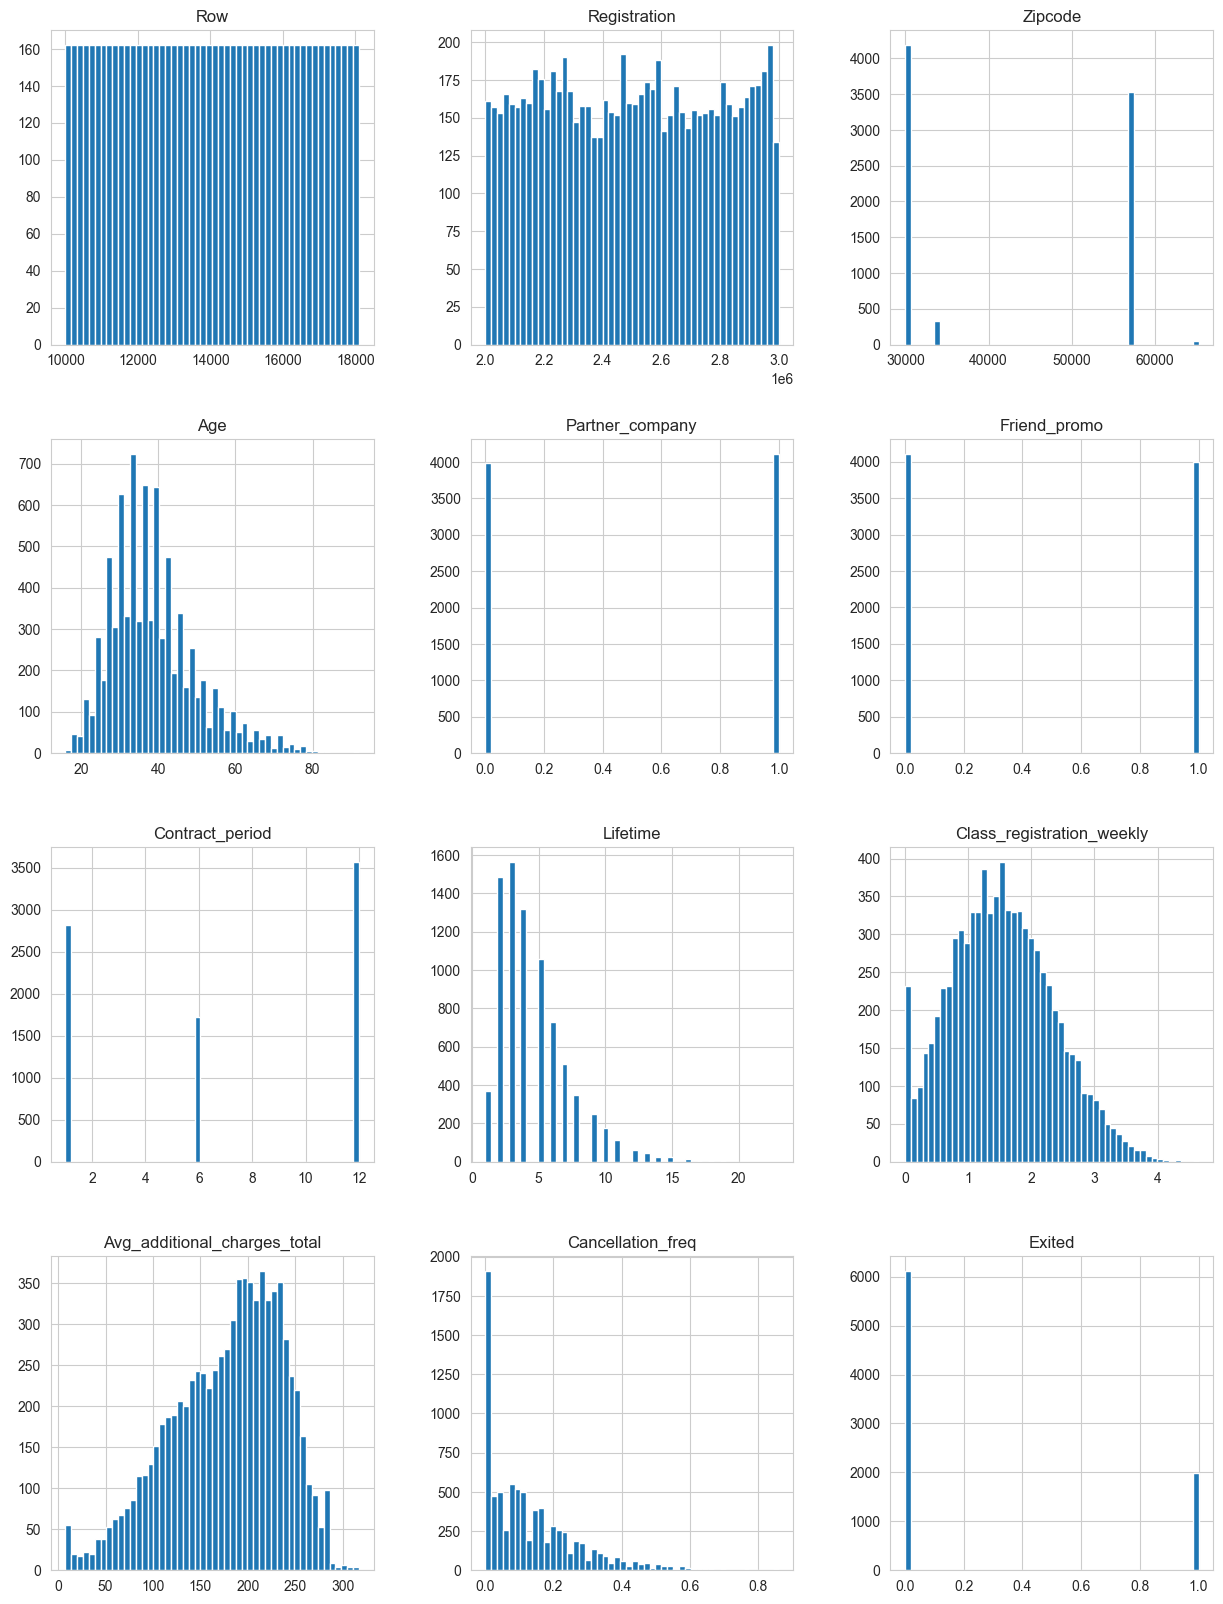

In [183]:
data.hist(bins=50, figsize=(15, 20));
None

### Общий вывод: Оба датасета подготовлены к дальнейшему анализу.

In [184]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
Row,0.000000
Registration,0.000000
Zipcode,0.000000
Age,0.000000
Partner_company,0.000000
Friend_promo,0.000000
Contract_period,0.000000
Lifetime,0.000000
Class_registration_weekly,0.000000
Avg_additional_charges_total,0.000000


### Проверка данных на явные дубликаты

In [185]:
data.duplicated().sum()

0

### Финальная проверка таргета на дисбаланс и аномалии различного рода

In [186]:
data['Exited'].unique()

array([0, 1], dtype=int64)

In [187]:
# проверка на дисбаланс
data['Exited'].value_counts()

0    6117
1    1983
Name: Exited, dtype: int64

### Проверка признаков на мультиколлинеарность

In [188]:
data.corr()

,Row,Registration,Zipcode,Age,Partner_company,Friend_promo,Contract_period,Lifetime,Class_registration_weekly,Avg_additional_charges_total,Cancellation_freq,Exited
Row,1.000000,0.999936,0.012913,0.014521,0.005147,-0.009184,0.003929,-0.005669,-0.002320,0.008209,-0.017285,-0.001439
Registration,0.999936,1.000000,0.012945,0.014428,0.005111,-0.009231,0.004081,-0.005358,-0.002280,0.008094,-0.017310,-0.001464
Zipcode,0.012913,0.012945,1.000000,-0.120193,0.001835,0.009833,0.082698,0.079364,0.119956,0.145650,-0.126776,-0.301095
Age,0.014521,0.014428,-0.120193,1.000000,0.001319,0.015340,-0.077715,-0.116899,-0.128960,-0.229965,0.162721,0.373492
Partner_company,0.005147,0.005111,0.001835,0.001319,1.000000,-0.411229,-0.001470,0.011820,0.007755,0.019319,0.001991,-0.011876
Friend_promo,-0.009184,-0.009231,0.009833,0.015340,-0.411229,1.000000,0.000475,-0.014500,0.000154,0.034762,-0.025547,-0.021422
Contract_period,0.003929,0.004081,0.082698,-0.077715,-0.001470,0.000475,1.000000,0.076211,0.092774,0.100585,-0.115249,-0.254760
Lifetime,-0.005669,-0.005358,0.079364,-0.116899,0.011820,-0.014500,0.076211,1.000000,0.096470,0.161282,-0.124104,-0.296143
Class_registration_weekly,-0.002320,-0.002280,0.119956,-0.128960,0.007755,0.000154,0.092774,0.096470,1.000000,0.213975,0.300244,-0.380576
Avg_additional_charges_total,0.008209,0.008094,0.145650,-0.229965,0.019319,0.034762,0.100585,0.161282,0.213975,1.000000,-0.171120,-0.541993


## Исследовательский анализ данных

In [189]:
data.columns

Index(['Row', 'Registration', 'Zipcode', 'Age', 'Partner_company',
       'Friend_promo', 'Contract_period', 'Lifetime',
       'Class_registration_weekly', 'Avg_additional_charges_total',
       'Cancellation_freq', 'Exited'],
      dtype='object')

In [190]:
def desc_stat(data, column):
    # descriptive statistics
    print(data[column].describe())
    data.boxplot(column=column, figsize=(3,7));
    plt.title('Descriptive Statistics')
    plt.show()
    data[column].hist(bins=30, range=(0, 110), figsize=(15, 5));

count    8.100000e+03
mean     2.499954e+06
std      2.897209e+05
min      2.000159e+06
25%      2.246722e+06
50%      2.499496e+06
75%      2.752443e+06
max      2.999894e+06
Name: Registration, dtype: float64


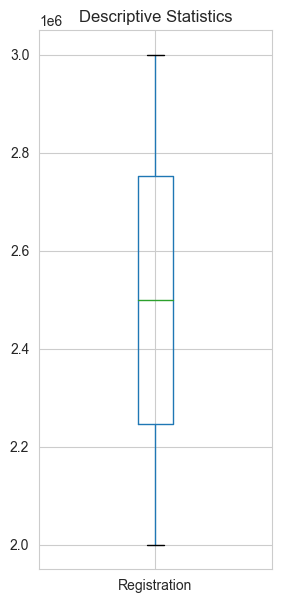

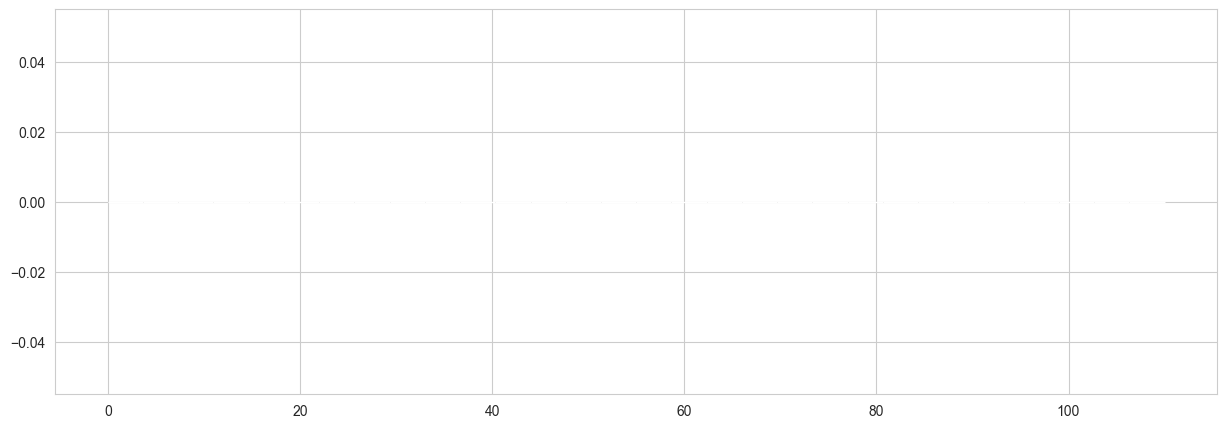

In [191]:
desc_stat(data, 'Registration')

count    8100.000000
mean       38.788395
std        11.071217
min        16.000000
25%        31.000000
50%        37.000000
75%        44.000000
max        92.000000
Name: Age, dtype: float64


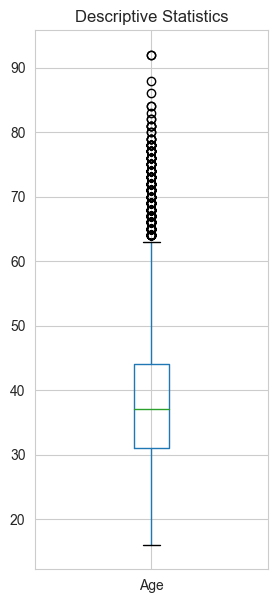

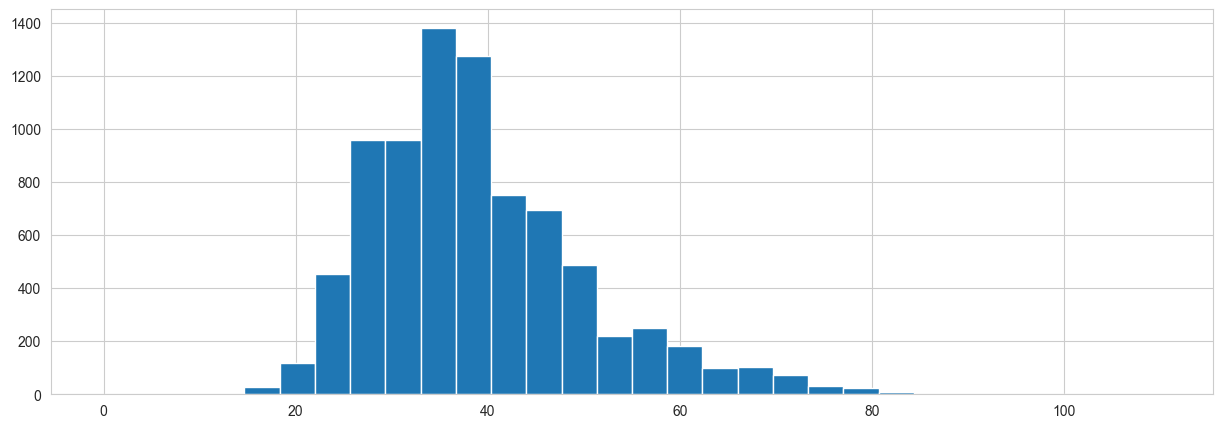

In [192]:
desc_stat(data, 'Age')

count    8100.000000
mean      177.894673
std        58.866795
min         7.600000
25%       137.280000
50%       187.220000
75%       223.000000
max       317.200000
Name: Avg_additional_charges_total, dtype: float64


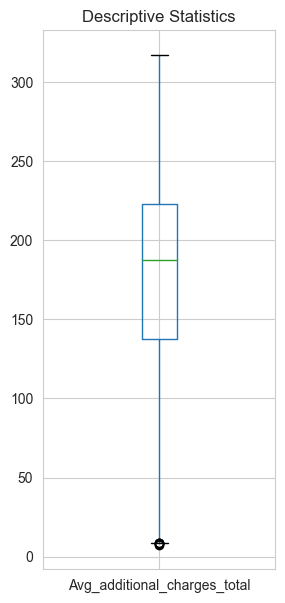

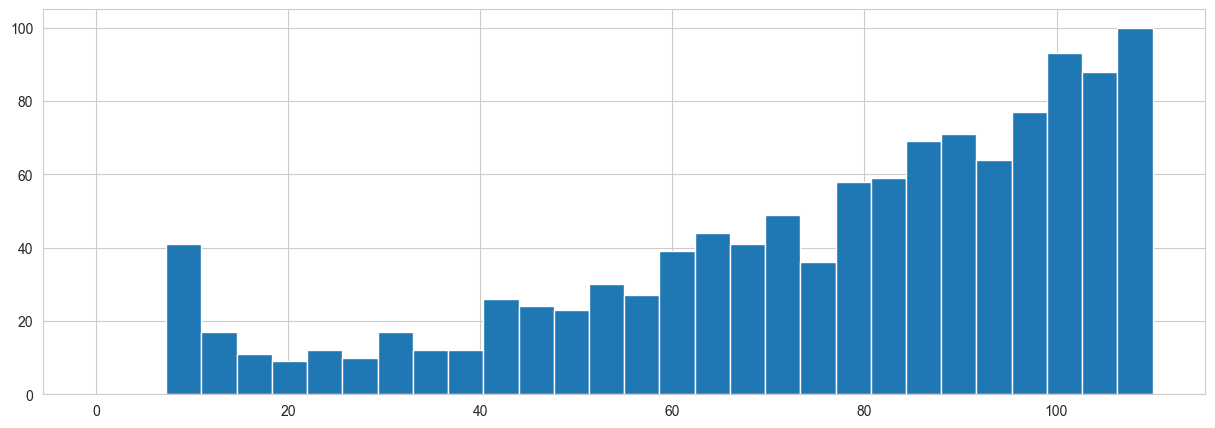

In [193]:
desc_stat(data, 'Avg_additional_charges_total')

count    8100.000000
mean        6.902716
std         4.868075
min         1.000000
25%         1.000000
50%         6.000000
75%        12.000000
max        12.000000
Name: Contract_period, dtype: float64


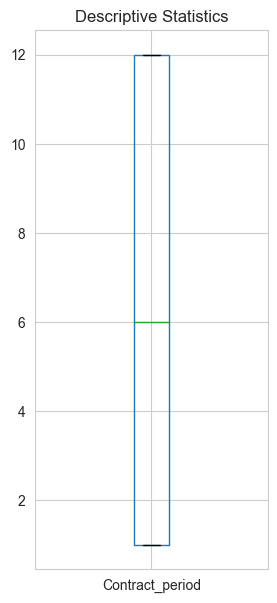

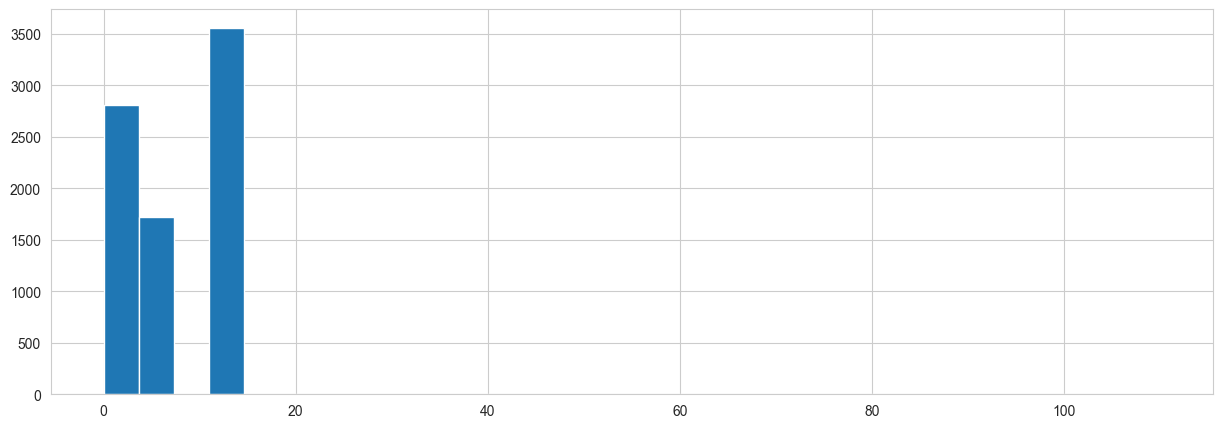

In [194]:
desc_stat(data, 'Contract_period')

count    8100.000000
mean        0.133910
std         0.138021
min         0.000000
25%         0.020000
50%         0.100000
75%         0.200000
max         0.860000
Name: Cancellation_freq, dtype: float64


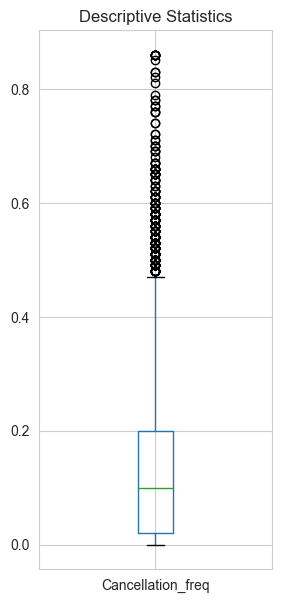

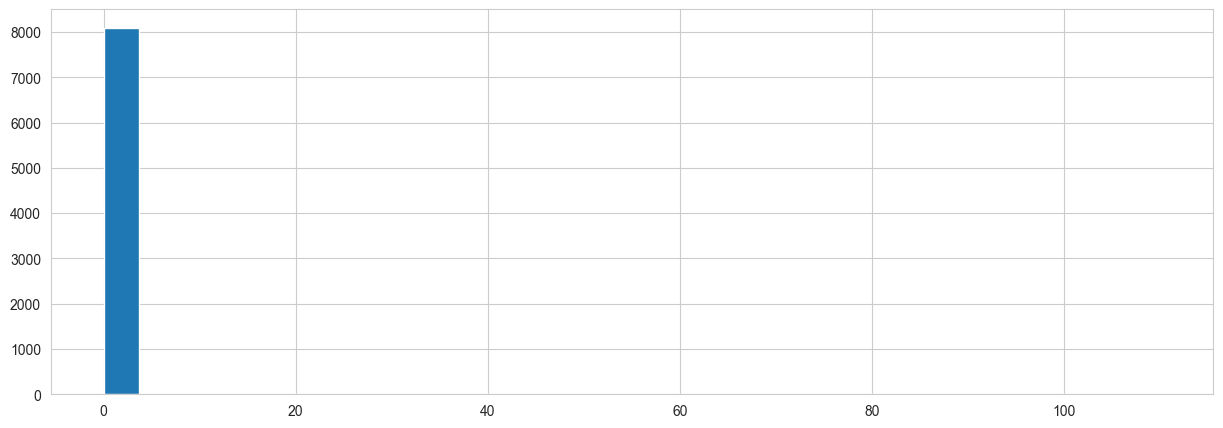

In [195]:
desc_stat(data, 'Cancellation_freq')

Индекс вряд ли оказывает влияние на модели, исключим его из признаков для обучения.

## Модели

### Деление выборки на подвыборки
```
- 75% train_data
- 25% test_data
```

In [196]:
RANDOM_STATE = 31032023

In [197]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE)

print('Размер обучающей выборки:', train_data.shape[0])
print('Размер тестовой выборки:', test_data.shape[0])

Размер обучающей выборки: 6075
Размер тестовой выборки: 2025


In [198]:
X_train = train_data.drop(['Exited'], axis=1)
y_train = train_data['Exited']

X_test = test_data.drop(['Exited'], axis=1)
y_test = test_data['Exited']

print('Обучающая выборка (признаки):', X_train.shape[0])
print('Обучающая выборка (таргет)', y_train.shape[0])
print()
print('Тестовая выборка (признаки):', X_test.shape[0])
print('Тестовая выборка (таргет)', y_test.shape[0])

Обучающая выборка (признаки): 6075
Обучающая выборка (таргет) 6075

Тестовая выборка (признаки): 2025
Тестовая выборка (таргет) 2025


### 1 [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [199]:
%%time
# Initiating and building Decision Tree model
parameters_dt = {
    'max_depth': [2, 3, 4, 5],
    'splitter': ['best', 'random'],
    'criterion': ['gini', 'entropy', 'log_loss']
}

dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

grid_DT = GridSearchCV(dt, param_grid=parameters_dt)

best_decision_tree_model = grid_DT.fit(X_train, y_train)

print('Наилучшие параметры для Decision Tree: {}'.format(best_decision_tree_model.best_params_))

Наилучшие параметры для Decision Tree: {'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}
CPU times: total: 1 s
Wall time: 1.18 s


### 2 [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [200]:
%%time
# Initiating and building Random Forest Regressor model
parameters_rf = {
    'n_estimators': [5, 10, 20, 50],
    'max_depth': [2, 3, 7],
    'criterion': ['gini', 'entropy', 'log_loss'],
}

rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
grid_RF = GridSearchCV(estimator=rf_model, param_grid=parameters_rf)
best_random_forest_model = grid_RF.fit(X_train, y_train)
print('Наилучшие параметры для Random Forest: {}'.format(best_random_forest_model.best_params_))

Наилучшие параметры для Random Forest: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 50}
CPU times: total: 13.5 s
Wall time: 13.8 s


### 3 Gradient Boosting
* [ссылка 1](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
* [ссылка 2](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae)

In [201]:
%%time
param_grid={'n_estimators':[5,10],
            'learning_rate': [0.1,0.04,0.05,0.02],
            'max_depth':[4],
            'min_samples_leaf':[3],
            'max_features':[1.0] }
n_jobs=4

estimator = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_classifier = GridSearchCV(estimator=estimator,
                          cv=5,
                          param_grid=param_grid,
                          n_jobs=n_jobs)

best_gb_model = gb_classifier.fit(X_train, y_train)
print('Наилучшие параметры для Gradient Descent: {}'.format(best_gb_model.best_params_))

Наилучшие параметры для Gradient Descent: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 1.0, 'min_samples_leaf': 3, 'n_estimators': 10}
CPU times: total: 125 ms
Wall time: 2.57 s


In [155]:
print(best_gb_model.best_estimator_)

GradientBoostingClassifier(max_depth=4, max_features=1.0, min_samples_leaf=3,
                           n_estimators=10, random_state=31032023)


### Сравнение качества моделей по кросс-валидации

In [156]:
# Decision Tree
best_score_dt = round(best_decision_tree_model.best_score_, 5)
print('Best score Decision Tree: {}'.format(best_score_dt))

train_predicted_dt = best_decision_tree_model.predict(X_train)
print("TRAIN Decision Tree Model, F1:", f1_score(y_train, train_predicted_dt))

Best score Decision Tree: 0.93564
TRAIN Decision Tree Model, F1: 0.8870967741935484


In [157]:
# Random Forest
best_score_rf = round(best_random_forest_model.best_score_, 5)
print('Best score Random Forest: {}'.format(best_score_rf))

train_predicted_rf = best_random_forest_model.predict(X_train)
print("TRAIN Random Forest Model, F1:", f1_score(y_train, train_predicted_rf))

Best score Random Forest: 0.96872
TRAIN Random Forest Model, F1: 0.9575633127994525


In [158]:
# Gradient Boosting
best_score_gb = round(best_gb_model.best_score_, 5)
print('Best score Gradient Boosting: {}'.format(best_score_gb))

train_predicted_gb = best_gb_model.predict(X_train)
print("TRAIN Random Forest Model, F1:", f1_score(y_train, train_predicted_rf))

Best score Gradient Boosting: 0.9414
TRAIN Random Forest Model, F1: 0.9575633127994525


### *Вывод:* Наивысший скор по кросс-валидации получил Random Forest, F1: 0.958.

## Тестируем лучшую модель (Random Forest) на тестовой выборке и делаем тестовые предсказания

In [159]:
test_predicted_rf = best_random_forest_model.predict(X_test)
print("TEST RF Model, F1:", f1_score(y_test, test_predicted_rf))

TEST RF Model, F1: 0.9279661016949152


### *Вывод*: Видим, что на тесте F1-метрика немного снижается, но не резко. Это говорит о том, что гиперпараметры заданы хорошо, а модель обучилась без подстраивания под тренировочную выборку, то есть переобучения нет.

Построим метрику ROC-AUC для лучшей модели.

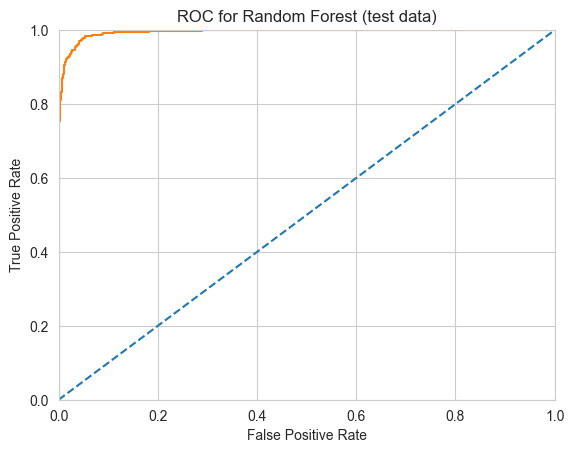

In [160]:
probabilities_test_rf = best_random_forest_model.predict_proba(X_test)
probabilities_one_test_rf = probabilities_test_rf[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test_rf)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC for Random Forest (test data)')
plt.show();

## Предсказания на реальных данных

In [205]:
test.head()

,Row,Registration,Zipcode,Age,Partner_company,Friend_promo,Contract_period,Lifetime,Class_registration_weekly,Avg_additional_charges_total,Cancellation_freq,Exited
0,1001,2006682,29941,36,0,1,6,2,0.72,225.666667,0.01,NaN
1,1002,2008504,57328,37,1,0,12,8,1.29,166.666667,0.11,NaN
2,1003,2020638,33726,50,1,1,1,2,1.18,101.430000,0.12,NaN
3,1004,2021568,29941,38,0,1,12,5,0.13,215.000000,0.00,NaN
4,1005,2028557,33726,28,0,1,12,11,1.25,160.720000,0.13,NaN


In [206]:
test_pred = test.drop(columns='Exited')

In [207]:
# Random Forest
y_pred_rf = best_random_forest_model.predict(test_pred)
y_pred_rf

array([0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0], dtype=int64)

In [208]:
test_pred['Exited'] = best_random_forest_model.predict(test_pred)

In [211]:
test_pred.to_csv("C:\\Users\\HOME\\Documents\\Yandex\\gym_test.csv", index=False)

In [210]:
test_pred

,Row,Registration,Zipcode,Age,Partner_company,Friend_promo,Contract_period,Lifetime,Class_registration_weekly,Avg_additional_charges_total,Cancellation_freq,Exited
0,1001,2006682,29941,36,0,1,6,2,0.72,225.666667,0.01,0
1,1002,2008504,57328,37,1,0,12,8,1.29,166.666667,0.11,0
2,1003,2020638,33726,50,1,1,1,2,1.18,101.430000,0.12,1
3,1004,2021568,29941,38,0,1,12,5,0.13,215.000000,0.00,0
4,1005,2028557,33726,28,0,1,12,11,1.25,160.720000,0.13,0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,1196,2975983,57328,34,1,0,1,3,3.29,188.000000,0.12,0
196,1197,2976461,57328,46,0,1,12,9,0.93,205.000000,0.00,0
197,1198,2985140,29941,33,0,0,1,2,1.52,65.450000,0.30,1
198,1199,2993255,29941,38,0,0,1,2,1.39,56.640000,0.20,1


### Изучим важность признаков

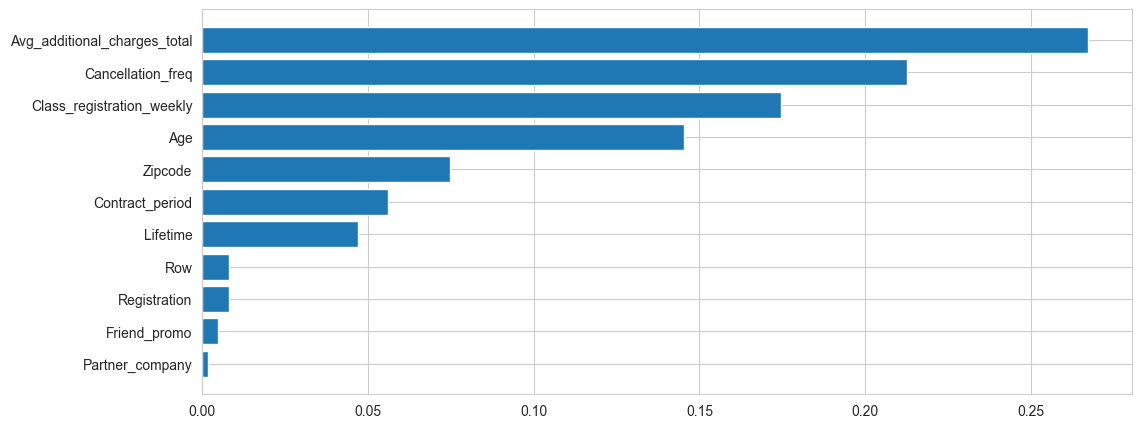

In [167]:
importance = best_random_forest_model.best_estimator_.feature_importances_
indices = np.argsort(importance)

fig, ax = plt.subplots(figsize=(12, 5))
ax.barh(range(len(importance)), importance[indices])
ax.set_yticks(range(len(importance)))
_ = ax.set_yticklabels(np.array(test_data.drop(columns=['Exited']).columns)[indices])

### *Вывод:* Видим, что сильнее всего на отток влияют расходы клиента, частота расторжения контракта, продолжительность подписки в месяцах и возраст.